# Monte Carlo - Standoff Calculation

Author: Tobin Ford | tobin.ford@nrel.gov

2023
***
See Monte Carlo - Arrhenius Degredation for a more in depth guide. Steps will be shortened for brevity.

**Objectives**


In [ ]:
# if running on google colab, uncomment the next line and execute this cell to install the dependencies and prevent "ModuleNotFoundError" in later cells:
# !pip install pvdeg==0.2.0

In [1]:
import pvlib
import numpy as np
import pandas as pd
import pvdeg
import matplotlib.pyplot as plt

In [2]:
# This information helps with debugging and getting support :)
import sys, platform
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("Pvlib version ", pvlib.__version__)
print("Pvdeg version ", pvdeg.__version__)

Working on a  Windows 10
Python version  3.10.9 | packaged by Anaconda, Inc. | (main, Mar  8 2023, 10:42:25) [MSC v.1916 64 bit (AMD64)]
Pandas version  2.1.2
Pvlib version  0.10.2
Pvdeg version  0.2.0+57.g91448fd.dirty


### Simple Standoff Calculation

This is copied from another tutorial called `4 - Standards.ipynb`, please visit this page for a more in depth explanation of the process for a single standoff calculation.

<div class="alert alert-block alert-info">
<b>Please use your own API key: The block below makes an NSRDB API to get weather and meta data. This tutorial will work with the DEMO Key provided, but it will take you less than 3 minutes to obtain your own at <a ref="https://developer.nrel.gov/signup/">https://developer.nrel.gov/signup/</a> so register now.) 
</div>

In [3]:
weather_db = 'PSM3'
weather_id = (40.633365593159226, -73.9945801019899) # Manhattan, NYC
weather_arg = {'api_key': 'DEMO_KEY',
               'email': 'user@mail.com', 
               'names': 'tmy',
               'attributes': [],
               'map_variables': True}

WEATHER, META = pvdeg.weather.get(weather_db, weather_id, **weather_arg)

Column "relative_humidity" not found in DataFrame. Calculating...


In [4]:
# simple standoff calculation
height1 = pvdeg.standards.standoff(
    weather_df = WEATHER,
    meta = META
    )

# more arguments standoff calculation
height2 = pvdeg.standards.standoff(weather_df=WEATHER, meta=META,
    level=2,
    tilt=None,
    azimuth=180,
    sky_model='isotropic',
    temp_model='sapm',
    module_type='glass_polymer',
    x_0=6.1,
    wind_speed_factor=1
    )

print(height1)
print(height2)

          x      T98_0    T98_inf
0  0.608698  72.506496  46.113842
          x      T98_0    T98_inf
0 -1.524517  72.506496  46.113842


### Defining Correlation Coefficients, Mean and Standard Deviation For Monte Carlo Simulation

We will leave the list of correlations blank because our variables are not correlated. For a correlated use case visit the `Monte Carlo - Arrhenius.ipynb` tutorial.

Mean and standard deviation must always be populated if being used to create a dataset. However, you can feed your own correlated or uncorrelated data into the simulate function but column names must be consistent.

In [5]:
# These numbers may not make sense in the context of the problem but work for demonstraiting the process
stats = {
    'X_0' : {'mean' : 5, 'stdev' : 3},
    'wind_speed_factor' : {'mean' : 0.5, 'stdev' : 0.2} 
}

corr_coeff = []

samples = pvdeg.montecarlo.generateCorrelatedSamples(corr_coeff, stats, 500)

In [6]:
print(samples)

           X_0  wind_speed_factor
0     4.454747           0.620919
1     4.673040           0.598282
2     4.282063           0.774080
3     5.744488           0.580695
4     2.414071           0.585449
..         ...                ...
495   5.742209           0.918980
496   2.313993           0.809623
497   6.415451           0.065931
498   5.101291           0.401342
499  11.265788           0.455911

[500 rows x 2 columns]


#### Standoff Monte Carlo Inputs

When using the pvdeg.montecarlo.simulate() function on a target function all of the target function's required arguments must still be given. Our non-changing arguments will be stored in a dictionary. The randomized monte carlo input data will also be passed to the target function via the simulate function. All required target function arguments should be contained between the column names of the randomized input data and fixed argument dictionary, 

In [7]:
# defining arguments to pass to the target function, standoff() in this case
function_kwargs = {
    'weather_df' : WEATHER,
    'meta' : META,
    'level' : 2,
    'tilt' : None,
    'azimuth' : 180,
    'sky_model' : 'isotropic',
    'temp_model' : 'sapm',
    'module_type' : 'glass_polymer'
} 
# notice how we left off parts we want to use in the monte carlo simulation because they are already contained in the dataframe

results = pvdeg.montecarlo.simulate(
    func=pvdeg.standards.standoff, 
    correlated_samples=samples, # in this case correlated_samples is a misnomer, they are not required to be correlated
    **function_kwargs)

#### Dealing With Series 
Notice how our results are contained in a pandas series instead of a dataframe.

This means we have to do an extra step to view our results. Run the block below to confirm that our results are indeed contained in a series. And convert them into a simpler dataframe.

In [8]:
print(type(results))

# Convert from pandas Series to pandas DataFrame
results_df = pd.concat(results.tolist()).reset_index(drop=True)

<class 'pandas.core.series.Series'>


In [9]:
print(results_df)

            x      T98_0    T98_inf
0   -0.784450  74.761782  47.557203
1   -0.788661  74.977053  47.655517
2   -0.891519  73.772777  46.868406
3   -0.946082  75.100866  47.736310
4   -0.400590  75.063245  47.713097
..        ...        ...        ...
495 -1.344599  72.986653  46.405576
496 -0.493946  73.610036  46.756298
497 -0.306209  78.615474  50.294718
498 -0.646186  76.255218  48.525034
499 -1.615139  75.763844  48.283638

[500 rows x 3 columns]


### Viewing Our Data
Let's plot the results using a histogram

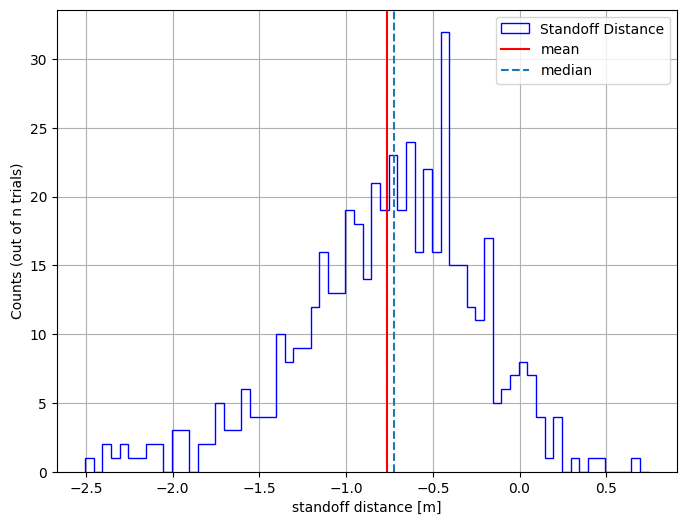

In [10]:
bin_edges = np.arange(results_df['x'].min(), results_df['x'].max() + 0.1, 0.05)
plt.figure(figsize=(8,6))
plt.hist(results_df['x'], bins=bin_edges, edgecolor='blue', histtype='step', linewidth=1, label = 'Standoff Distance')
plt.ylabel('Counts (out of n trials)')
plt.xlabel('standoff distance [m]')
plt.axvline(np.mean(results_df['x']), color = 'red', label = 'mean' )
plt.axvline(np.median(results_df['x']), linestyle='--', label = 'median')

plt.legend()
plt.grid(True)
plt.show()